# Turnstile jump in 2020
### Nov 5 2022

### three things are done in the following analysis :
#### data cleaning
- filter year
- remove zero value for entry and exit
- change column names 
- change value format for each column

#### calculate the net change for each station
- identify initial value
- identify ending value
- calculate the net change all year for all station
- calculate the money loss

#### join geo information and visualization 
- seems we can match 718 out of 751 station for geo information.
- absolute difference and normalized difference regarding entry/exit
- number of booth and absolute difference

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None) # show all columns


In [2]:
# df = pd.read_csv("data/Turnstile_Usage_Data__2020.csv")
df = pd.read_csv("data/Turnstile_Usage_Data__2019.csv")
df.Date = pd.to_datetime(df['Date'])
# df.Time = pd.to_datetime(df['Time'])

df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['day'] = df.Date.dt.day
df['hour'] = df['Time'].apply(lambda x: x[:2]) # get hour

df['minute'] =  df['Time'].apply(lambda x: x[3:5])# get min
df['dow'] = df.Date.dt.dayofweek

print(df.shape)
print(df.month.nunique())

(13318000, 17)
12


## 1. sanity check

In [3]:
################################ 
#### pre-processing
################################ 
cols = list(df.columns)
for col in cols:
    #() you may find the year here is not only one as we expected. )
    print(col, df[col].nunique())

C/A 752
Unit 470
SCP 236
Station 379
Line Name 124
Division 6
Date 357
Time 83943
Description 2
Entries 5384671
Exits                                                      4889978
month 12
year 3
day 31
hour 24
minute 60
dow 7


In [4]:
df = df.loc[df['year'] == 2020]
print(df.shape) 

(13169542, 17)


In [5]:
# the exits and entries is in text rather than numeric format. 
# change both entries and exits.

df = df.rename(columns = {'Exits                                                     ':'Exits'})
df.Entries = df.Entries.apply(lambda x : x.replace(",", ""))
df.Exits = df.Exits.apply(lambda x : x.replace(",", ""))

df.Entries = pd.to_numeric(df.Entries)
df.Exits = pd.to_numeric(df.Exits)
df.hour = pd.to_numeric(df.hour)
df.minute = pd.to_numeric(df.minute)

In [6]:
##############
## remove entry/ exit = 0
##############

## after check the data, we found when entry/exit = 0, the cumulative counter in the opposite direction also does not work.
## so for net change accuracy, we first remove zero entries.
df = df.loc[~((df.Entries==0)|(df.Exits==0))]
print(df.shape) # the value is still large. We lost 5% data size.

(12470504, 17)


In [7]:
# For now, we are not going to remove the extrem large value, 
# since it is possible that the initialization value of the counter is large.
df.describe()

Entries         Exits         month        year           day  \
count  1.247050e+07  1.247050e+07  1.247050e+07  12470504.0  1.247050e+07   
mean   4.467188e+07  3.696976e+07  6.360228e+00      2020.0  1.611794e+01   
std    2.241885e+08  2.036400e+08  3.288821e+00         0.0  8.554938e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00      2020.0  1.000000e+00   
25%    3.820418e+05  1.939510e+05  3.000000e+00      2020.0  9.000000e+00   
50%    2.056409e+06  1.260428e+06  6.000000e+00      2020.0  1.700000e+01   
75%    6.693000e+06  4.701275e+06  9.000000e+00      2020.0  2.300000e+01   
max    2.128890e+09  2.123494e+09  1.200000e+01      2020.0  3.100000e+01   

               hour        minute           dow  
count  1.247050e+07  1.247050e+07  1.247050e+07  
mean   1.088512e+01  2.612385e+00  3.002408e+00  
std    6.910638e+00  9.596235e+00  1.996404e+00  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    5.000000e+00  0.000000e+00  1.000000e+00  
50%    1.100000e+01  0.000000e+00  3.000000e+00  
75%    1.600000e+01  0.000000e+00  5.000000e+00  
max    2.300000e+01  5.900000e+01  6.000000e+00

In [8]:
# #filter out the outliers
df_clean = df[(df['Entries'] >= df['Entries'].quantile(0.01)) & (df['Entries'] <= df['Entries'].quantile(0.99))\
         &(df['Exits'] >= df['Exits'].quantile(0.01)) & (df['Exits'] <= df['Exits'].quantile(0.99))] 
df_clean.shape

(12047294, 17)

### 2. Calculate the net change for each booth

In [26]:
def netChangeYearly(df):
    """
    calculate the net change for each booth using the register recording entries/exits
    """

    ## each booth has a counter. 
    ## For each booth, we'll use the earliest timestamp (e.g., 2020-1-1 00:00) as their initalization value.
    df_begin = df.sort_values(by = ['C/A','Unit','SCP','Date','hour','minute']).drop_duplicates(['C/A','Unit','SCP'], keep='first')
    ## check the ending status for each station. (e.g., at the end of the year, the entry/exit value for each station.)
    df_end = df.sort_values(by = ['C/A','Unit','SCP','Date','hour','minute'], ascending = False).drop_duplicates(['C/A','Unit','SCP'], keep='first')
    
    ## calculate net change for each booth
    df_dif = df_begin[['C/A','Unit','SCP','Entries','Exits','Station']].merge(\
            df_end[['C/A','Unit','SCP','Entries','Exits']],left_on = ['C/A','Unit','SCP'\
             ],right_on = ['C/A','Unit','SCP'], how = 'inner')
    df_dif['ent_dif'] = df_dif['Entries_y'] - df_dif['Entries_x'] 
    df_dif['ext_dif'] = df_dif['Exits_y'] - df_dif['Exits_x']
    df_dif.columns = ['C/A','Unit','SCP','Ent_beg','Ext_beg','Station','Ent_end','Ext_end','Ent_dif','Ext_dif']

    return df_dif

In [27]:
df_net = netChangeYearly(df_clean)
df_net.head(3)

C/A  Unit       SCP  Ent_beg  Ext_beg Station  Ent_end  Ext_end  Ent_dif  \
0  A002  R051  02-00-00  7328037  2483731   59 ST  7511447  2558784   183410   
1  A002  R051  02-00-01  6511722  1463438   59 ST  6659237  1509205   147515   
2  A002  R051  02-03-00  1336164  5041658   59 ST  1407713  5309084    71549   

   Ext_dif  
0    75053  
1    45767  
2   267426

In [18]:
#######################
### sanity check for the net change
######################

# #filter out the outliers
df_net_clean = df_net[(df_net['Ent_dif'] >= df_net['Ent_dif'].quantile(0.01)) & (df_net['Ent_dif'] <= df_net['Ent_dif'].quantile(0.99))\
         &(df_net['Ext_dif'] >= df_net['Ext_dif'].quantile(0.01)) & (df_net['Ext_dif'] <= df_net['Ext_dif'].quantile(0.99))] 
df_net_clean.shape

In [293]:
#######################
### yearly money loss for turnstile jump
######################

# the money loss for whole turnstile jump
# around 500 million

# turnstile jump total trips
trip = (df_net_clean.Ent_dif.sum() - df_net_clean.Ext_dif.sum())
money_loss= trip*2.79

print(trip)
print('yearly money loss: ${}'.format(np.abs(money_loss)))

-176984063
yearly money loss: $493785535.77


In [65]:
df_net_clean['normDif'] = (df_net_clean['Ent_dif'] - df_net_clean['Ext_dif'] ) /df_net_clean['avg_vol']
df_net_clean

C/A  Unit       SCP  Ent_beg  Ext_beg        Station  Ent_end  \
0      A002  R051  02-00-00  7328037  2483731          59 ST  7511447   
1      A002  R051  02-00-01  6511722  1463438          59 ST  6659237   
2      A002  R051  02-03-00  1336164  5041658          59 ST  1407713   
3      A002  R051  02-03-01  1372754  2102008          59 ST  1532132   
4      A002  R051  02-03-02  6457283  8630207          59 ST  6614806   
...     ...   ...       ...      ...      ...            ...      ...   
4658  TRAM2  R469  00-00-01  3368720    40859  RIT-ROOSEVELT  3625654   
4659  TRAM2  R469  00-03-00   732600    28814  RIT-ROOSEVELT   753040   
4660  TRAM2  R469  00-03-01  3114198   395143  RIT-ROOSEVELT  3133524   
4661  TRAM2  R469  00-05-00     3037       62  RIT-ROOSEVELT     3191   
4662  TRAM2  R469  00-05-01     5554      420  RIT-ROOSEVELT     5554   

      Ext_end  Ent_dif  Ext_dif  avg_vol   normDif  
0     2558784   183410    75053   258463  0.419236  
1     1509205   147515    45767   193282  0.526423  
2     5309084    71549   267426   338975 -0.577851  
3     2384227   159378   282219   441597 -0.278174  
4     8830571   157523   200364   357887 -0.119705  
...       ...      ...      ...      ...       ...  
4658    47905   256934     7046   263980  0.946617  
4659    30728    20440     1914    22354  0.828755  
4660   397443    19326     2300    21626  0.787293  
4661       62      154        0      154  1.000000  
4662      541        0      121      121 -1.000000  

[4529 rows x 12 columns]

In [66]:
df_net_clean.normDif.describe()

count    4503.000000
mean        0.081493
std         1.733996
min       -34.035330
25%        -0.243638
50%         0.081103
75%         0.422220
max       102.711027
Name: normDif, dtype: float64

In [ ]:
# # save file
# df_net_clean.to_csv('data/Turnstile_netChangeYearly_2020.csv')

## 3. Add geo location for each station

In [34]:
#### check geo location of the station. 
gdf = pd.read_csv("data/geocoded.csv", header = None)
gdf.columns=['Unit', 'stnID', 'stnname', 'linename' ,'originline', 'lat', 'lon']
print(gdf.shape)
gdf = gdf.loc[~pd.isna(gdf).any(axis=1), :]
print(gdf.shape)

(768, 7)
(750, 7)


In [35]:
# sanity check 
cols = list(gdf.columns)
for col in cols:
    print(col, gdf[col].nunique())

Unit 467
stnID 750
stnname 378
linename 109
originline 6
lat 449
lon 449


In [37]:
## check if the station of our turnstile dataset can find their geo location in this gdf dataset.

### seems we have 718 out of 752 station ID with lat and lon.
df_net_clean[df_net_clean['C/A'].isin(gdf.stnID)]['C/A'].nunique()

717

In [49]:
gdf_net_clean = df_net_clean.merge(gdf[['Unit','lat','lon']], left_on = 'Unit', right_on = 'Unit', how = 'left')
gdf_net_clean = gdf_net_clean.drop_duplicates().reset_index()
gdf_net_clean

index    C/A  Unit       SCP  Ent_beg  Ext_beg        Station  Ent_end  \
0         0   A002  R051  02-00-00  7328037  2483731          59 ST  7511447   
1         3   A002  R051  02-00-01  6511722  1463438          59 ST  6659237   
2         6   A002  R051  02-03-00  1336164  5041658          59 ST  1407713   
3         9   A002  R051  02-03-01  1372754  2102008          59 ST  1532132   
4        12   A002  R051  02-03-02  6457283  8630207          59 ST  6614806   
...     ...    ...   ...       ...      ...      ...            ...      ...   
4610   9378  TRAM2  R469  00-00-01  3368720    40859  RIT-ROOSEVELT  3625654   
4611   9379  TRAM2  R469  00-03-00   732600    28814  RIT-ROOSEVELT   753040   
4612   9380  TRAM2  R469  00-03-01  3114198   395143  RIT-ROOSEVELT  3133524   
4613   9381  TRAM2  R469  00-05-00     3037       62  RIT-ROOSEVELT     3191   
4614   9382  TRAM2  R469  00-05-01     5554      420  RIT-ROOSEVELT     5554   

      Ext_end  Ent_dif  Ext_dif        lat        lon  
0     2558784   183410    75053  40.762796 -73.967686  
1     1509205   147515    45767  40.762796 -73.967686  
2     5309084    71549   267426  40.762796 -73.967686  
3     2384227   159378   282219  40.762796 -73.967686  
4     8830571   157523   200364  40.762796 -73.967686  
...       ...      ...      ...        ...        ...  
4610    47905   256934     7046  40.757400 -73.954006  
4611    30728    20440     1914  40.757400 -73.954006  
4612   397443    19326     2300  40.757400 -73.954006  
4613       62      154        0  40.757400 -73.954006  
4614      541        0      121  40.757400 -73.954006  

[4615 rows x 13 columns]

In [84]:
sttgdf = stt.merge(gdf_net_clean[['Station','lat','lon','Unit']], left_on = 'Station',right_on= 'Station', how = 'inner')
sttgdf = sttgdf.drop_duplicates()
sttgdf

Station   Ent_dif   Ext_dif   abs_dif   avg_vol   normDif  \
0         PARKCHESTER  -7032684 -27968576  20935892 -35001260 -0.598147   
10           8 ST-NYU   -188593  -6027994   5839401  -6216587 -0.939326   
24    LEXINGTON AV/53  -2575929  -8099410   5523481 -10675339 -0.517406   
33    LEXINGTON AV/53  -2575929  -8099410   5523481 -10675339 -0.517406   
52        FRANKLIN ST   -236221  -5577493   5341272  -5813714 -0.918737   
...               ...       ...       ...       ...       ...       ...   
4548   34 ST-PENN STA -27597056 -16658810 -10938246 -44255866  0.247159   
4579  MYRTLE-WILLOUGH -16537902  -5074219 -11463683 -21612121  0.530428   
4584        DEKALB AV -17269388  -5352692 -11916696 -22622080  0.526773   
4599        DEKALB AV -17269388  -5352692 -11916696 -22622080  0.526773   
4603       5 AV/59 ST -23560554  -9047358 -14513196 -32607912  0.445082   

            lat        lon  Unit  
0     40.833246 -73.860805  R222  
10    40.730348 -73.992705  R085  
24    40.757530 -73.969102  R017  
33    40.757530 -73.969102  R016  
52    40.719323 -74.006953  R343  
...         ...        ...   ...  
4548  40.750264 -73.992984  R293  
4579  40.694568 -73.949046  R286  
4584  40.690612 -73.981848  R099  
4599  40.703839 -73.918440  R236  
4603  40.764909 -73.973372  R079  

[492 rows x 9 columns]

In [85]:
a = sttgdf.loc[(sttgdf.normDif<0)&(sttgdf.normDif>-1)].sort_values(by = 'normDif', ascending = True).head(15)
a

Station  Ent_dif   Ext_dif   abs_dif   avg_vol   normDif  \
3656   JAMAICA CENTER    63568   2890847  -2827279   2954415 -0.956967   
10           8 ST-NYU  -188593  -6027994   5839401  -6216587 -0.939326   
100        BEDFORD AV  -147403  -4470380   4322977  -4617783 -0.936159   
52        FRANKLIN ST  -236221  -5577493   5341272  -5813714 -0.918737   
1999    ORCHARD BEACH       19       308      -289       327 -0.883792   
3047     NEWARK HM HE    69127   1015216   -946089   1084343 -0.872500   
345   42 ST-PORT AUTH  -149853  -1577045   1427192  -1726898 -0.826448   
337   42 ST-PORT AUTH  -149853  -1577045   1427192  -1726898 -0.826448   
3097           168 ST   133085   1169409  -1036324   1302494 -0.795646   
399   SUTTER AV-RUTLD  -263234  -1565125   1301891  -1828359 -0.712054   
3021   KINGSBRIDGE RD   178413    959158   -780745   1137571 -0.686326   
3011   KINGSBRIDGE RD   178413    959158   -780745   1137571 -0.686326   
3170     BOROUGH HALL   353236   1570980  -1217744   1924216 -0.632852   
0         PARKCHESTER -7032684 -27968576  20935892 -35001260 -0.598147   
253    61 ST WOODSIDE  -933857  -3687153   2753296  -4621010 -0.595821   

            lat        lon  Unit  
3656  40.702131 -73.801110  R025  
10    40.730348 -73.992705  R085  
100   40.717241 -73.956614  R235  
52    40.719323 -74.006953  R343  
1999  40.852417 -73.828082  R459  
3047        NaN        NaN  R549  
345   40.757303 -73.989787  R011  
337   40.757303 -73.989787  R010  
3097  40.840778 -73.940091  R035  
399   40.664591 -73.922668  R063  
3021  40.867899 -73.897326  R161  
3011  40.866974 -73.893485  R155  
3170  40.692404 -73.990151  R108  
0     40.833246 -73.860805  R222  
253   40.745623 -73.902969  R147

In [86]:
b = sttgdf.loc[(sttgdf['Ent_dif']>0) & (sttgdf['Ext_dif']>0)].sort_values(by = 'abs_dif', ascending = True).head(15)
b

Station  Ent_dif  Ext_dif  abs_dif   avg_vol   normDif  \
3656  JAMAICA CENTER    63568  2890847 -2827279   2954415 -0.956967   
3225          103 ST   836548  2216444 -1379896   3052992 -0.451982   
3234          103 ST   836548  2216444 -1379896   3052992 -0.451982   
3228          103 ST   836548  2216444 -1379896   3052992 -0.451982   
3170    BOROUGH HALL   353236  1570980 -1217744   1924216 -0.632852   
3140   66 ST-LINCOLN   414195  1578917 -1164722   1993112 -0.584374   
3097          168 ST   133085  1169409 -1036324   1302494 -0.795646   
3075   FLUSHING-MAIN  3107657  4134234 -1026577   7241891 -0.141755   
3047    NEWARK HM HE    69127  1015216  -946089   1084343 -0.872500   
3021  KINGSBRIDGE RD   178413   959158  -780745   1137571 -0.686326   
3011  KINGSBRIDGE RD   178413   959158  -780745   1137571 -0.686326   
3007          145 ST  3839717  4610321  -770604   8450038 -0.091195   
3000          145 ST  3839717  4610321  -770604   8450038 -0.091195   
2991          145 ST  3839717  4610321  -770604   8450038 -0.091195   
2969  TIMES SQ-42 ST  6992418  7744216  -751798  14736634 -0.051016   

            lat        lon  Unit  
3656  40.702131 -73.801110  R025  
3225  40.796105 -73.961399  R314  
3234  40.790582 -73.947473  R180  
3228  40.799354 -73.968329  R191  
3170  40.692404 -73.990151  R108  
3140  40.773424 -73.982234  R164  
3097  40.840778 -73.940091  R035  
3075  40.759578 -73.830056  R055  
3047        NaN        NaN  R549  
3021  40.867899 -73.897326  R161  
3011  40.866974 -73.893485  R155  
3007  40.820402 -73.936315  R344  
3000  40.826426 -73.950412  R273  
2991  40.824787 -73.944232  R101  
2969  40.755905 -73.986504  R033

## 4. visualization (station-level)

In [88]:
%matplotlib notebook

bmap = plt.imread('data/streetmap.png')
# BBox = ((-74.3541, -73.5356,  40.4814, 40.9649))
BBox = ((-74.3060, -73.6626,  40.4710, 40.9343)) # the new basemap ref

#nyc boundary
url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'
nyc = gpd.read_file(url)

In [284]:
########################
## calculate the station level entry and exit, calculate the difference
#######################

stt = df_net_clean.groupby('Station').agg({'Ent_dif':'sum','Ext_dif':'sum'})
stt = stt.reset_index()
stt['abs_dif'] = stt['Ent_dif'] - stt['Ext_dif']
stt = stt.sort_values(by = ['abs_dif'], ascending = False)

stt['avg_vol'] = stt['Ent_dif'] + stt['Ext_dif']
stt['normDif'] = (stt['abs_dif'] ) /stt['avg_vol']
stt

In [299]:
## top 15 stations with larger exit than entry (absolute value)

# top 15 station for ent < ext (yearly stats)
b = stt.loc[(stt['Ent_dif']>0) & (stt['Ext_dif']>0)].sort_values(by = 'abs_dif', ascending = True).head(15)

## top15 accounts for 23.4% turnstile jump.

# z = np.abs(stt.loc[(stt['Ent_dif']>0) & (stt['Ext_dif']>0)].abs_dif).sum()
# np.abs(b.abs_dif).sum() / z*100

## top 15 stations with larger exit than entry (pound to pound)

# the value for net change
# normalized by the traffic volume for that station
a = stt.loc[(stt.normDif<0)&(stt.normDif>-1)].sort_values(by = 'normDif', ascending = True).head(15)

23.386788186641287

<IPython.core.display.Javascript object>


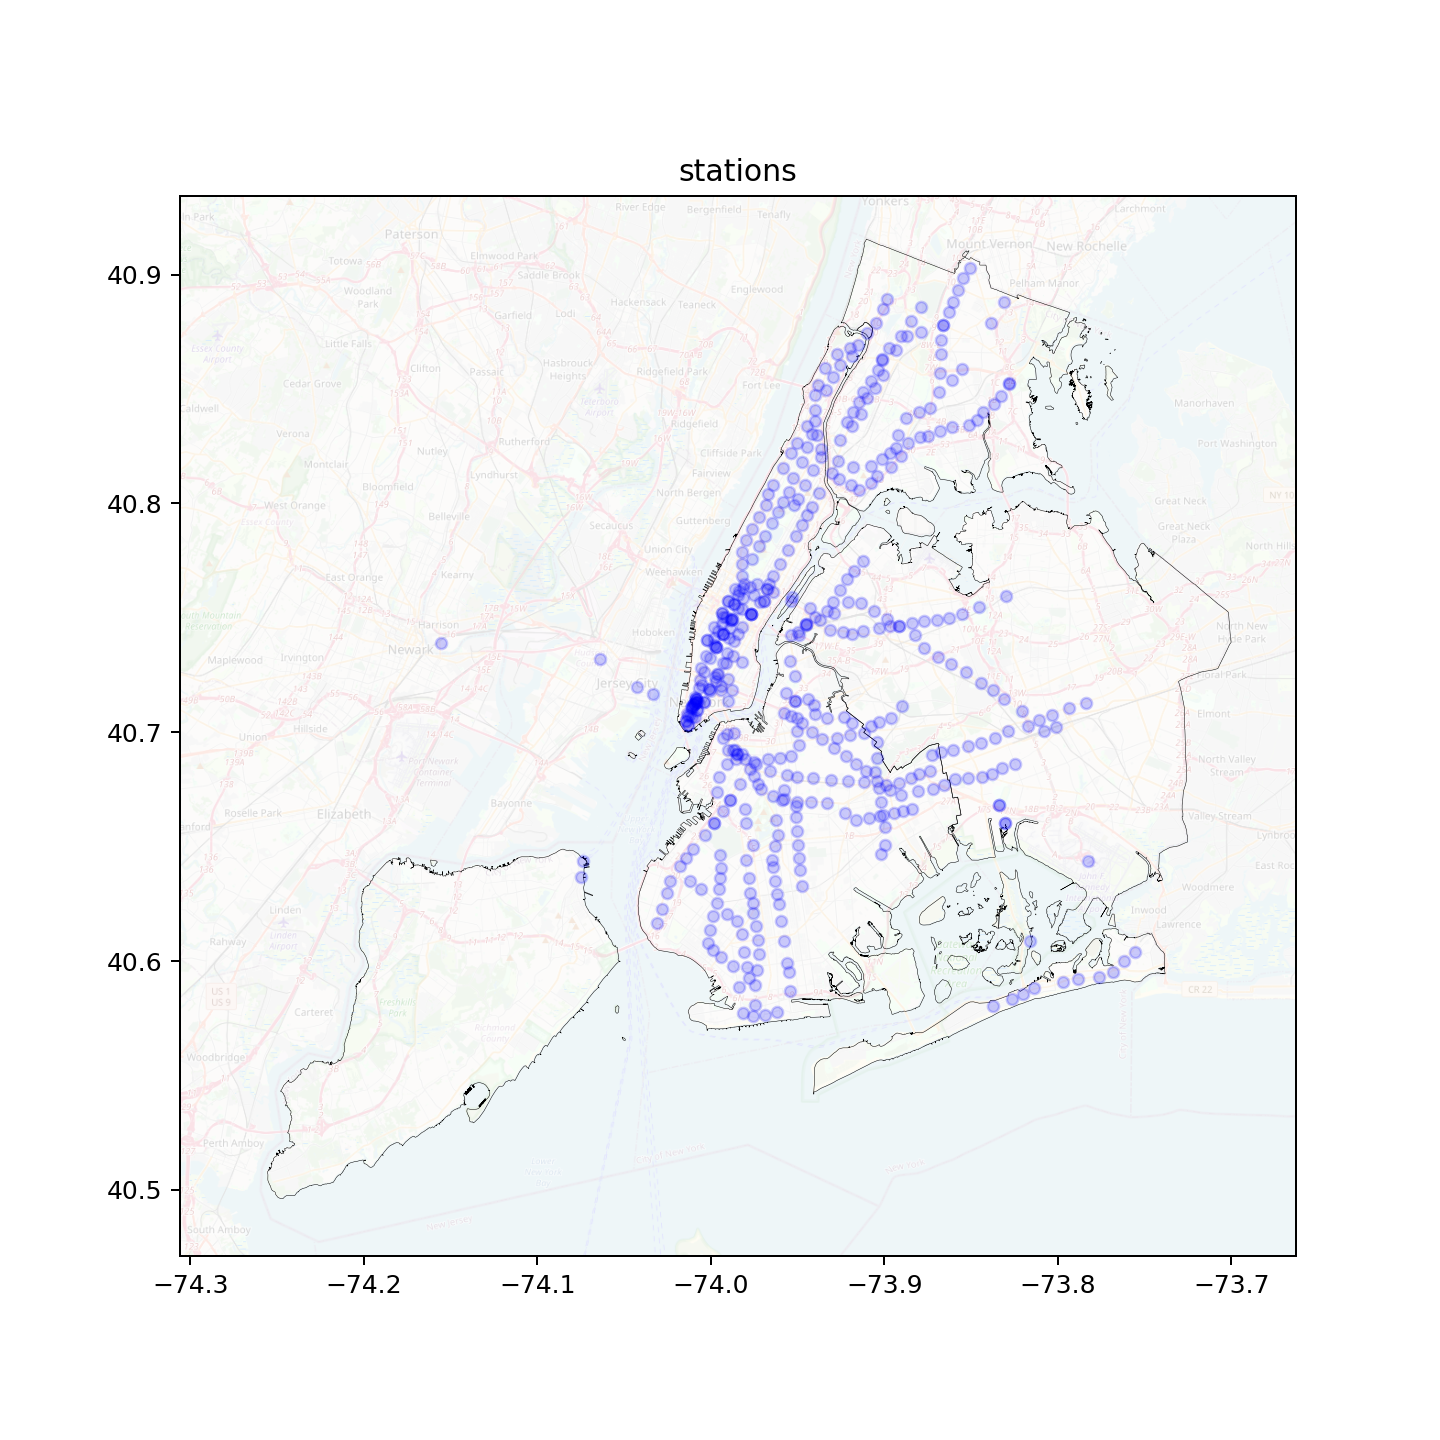

(40.471, 40.9343)

In [90]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(bmap, zorder=0, extent = BBox, aspect= 'equal', alpha = 0.2)
nyc.plot(ax = ax, facecolor = 'None',edgecolor = 'black',linewidth = 0.2)

# sttgdf.plot(ax = ax, column = 'code_stc', cmap = 'Paired', legend = True)
ax.scatter(sttgdf.lon, sttgdf.lat, zorder=1, alpha= 0.2, c='b', s=20)
ax.set_title('stations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

<IPython.core.display.Javascript object>


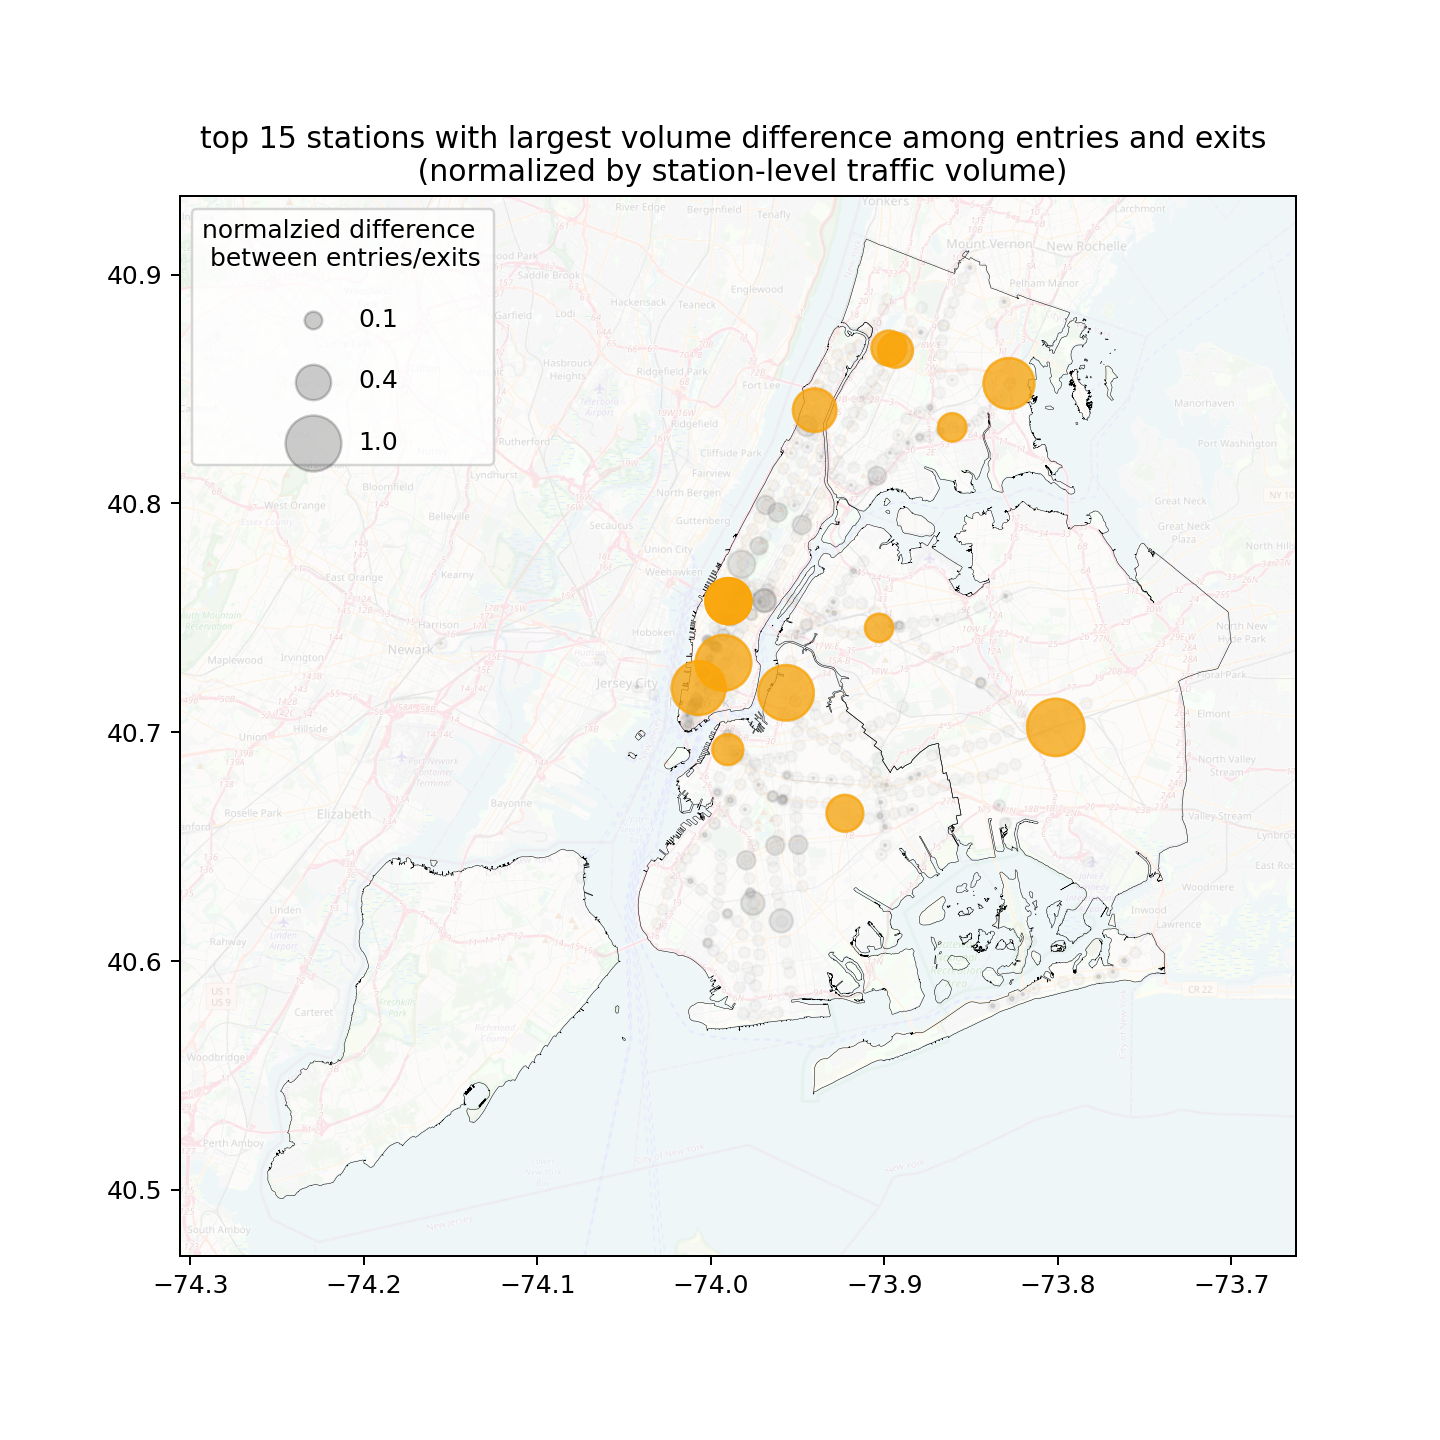

In [202]:
d = sttgdf.loc[(sttgdf.normDif<=1)&(sttgdf.normDif>=-1)]
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(bmap, zorder=0, extent = BBox, aspect= 'equal', alpha = 0.2)
nyc.plot(ax = ax, facecolor = 'None',edgecolor = 'black',linewidth = 0.2)

ax.scatter(sttgdf.lon, sttgdf.lat, alpha= 0.05, c='grey', s=20)
ax.scatter(d.lon, d.lat, alpha= 0.2, s = -600 * (d['normDif'])**3, c = 'grey')
ax.scatter(a.lon, a.lat, zorder=1, alpha= 0.7, s = -600 * (a['normDif'])**3, c = 'orange')

ax.set_title('top 15 stations with largest volume difference among entries and exits \n (normalized by station-level traffic volume)')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

for dif in [50,200,500]:
    plt.scatter([], [], c='k', alpha=0.2, s=dif,
               label=str((dif/500)))
plt.legend(scatterpoints=1, frameon=True,
                  labelspacing=1.5, title='normalzied difference \n between entries/exits')
# plt.legend()

<IPython.core.display.Javascript object>


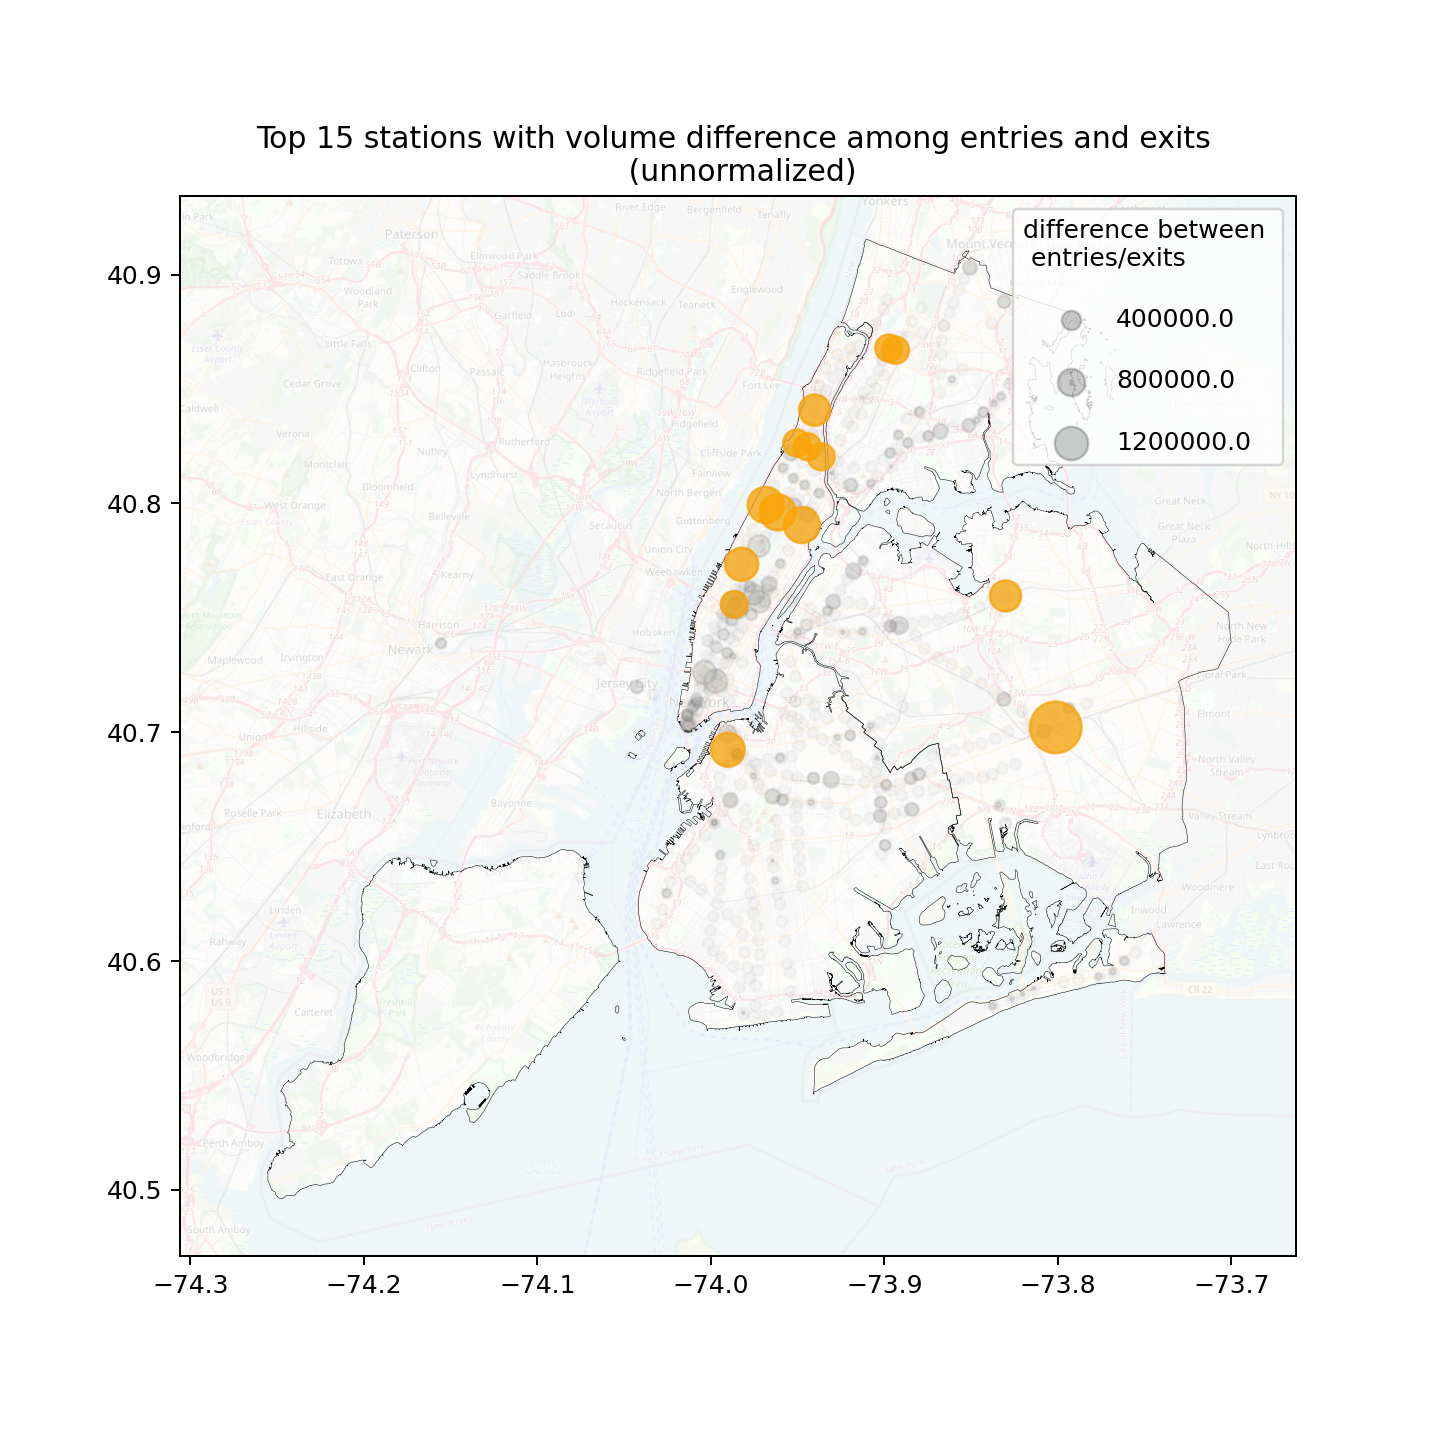

In [188]:
c = sttgdf.loc[(sttgdf['Ent_dif']>-1000) & (sttgdf['Ext_dif']>-1000)]
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(bmap, zorder=0, extent = BBox, aspect= 'equal', alpha = 0.2)
nyc.plot(ax = ax, facecolor = 'None',edgecolor = 'black',linewidth = 0.2)

ax.scatter(sttgdf.lon, sttgdf.lat, alpha= 0.05, c='grey', s=20)
ax.scatter(c.lon, c.lat, zorder=1, alpha= 0.2, s = -0.00015 * (c['abs_dif']), c = 'grey')
ax.scatter(b.lon, b.lat, zorder=1, alpha= 0.7, s = -0.00015 * (b['abs_dif']), c = 'orange')


ax.set_title('Top 15 stations with volume difference among entries and exits \n (unnormalized)')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

for dif in [60,120,180]:
    plt.scatter([], [], c='k', alpha=0.2, s=dif,
               label=str(round((1/0.00015)*dif,1)))
plt.legend(scatterpoints=1, frameon=True,
                  labelspacing=1.5, title='difference between \n entries/exits')

<IPython.core.display.Javascript object>


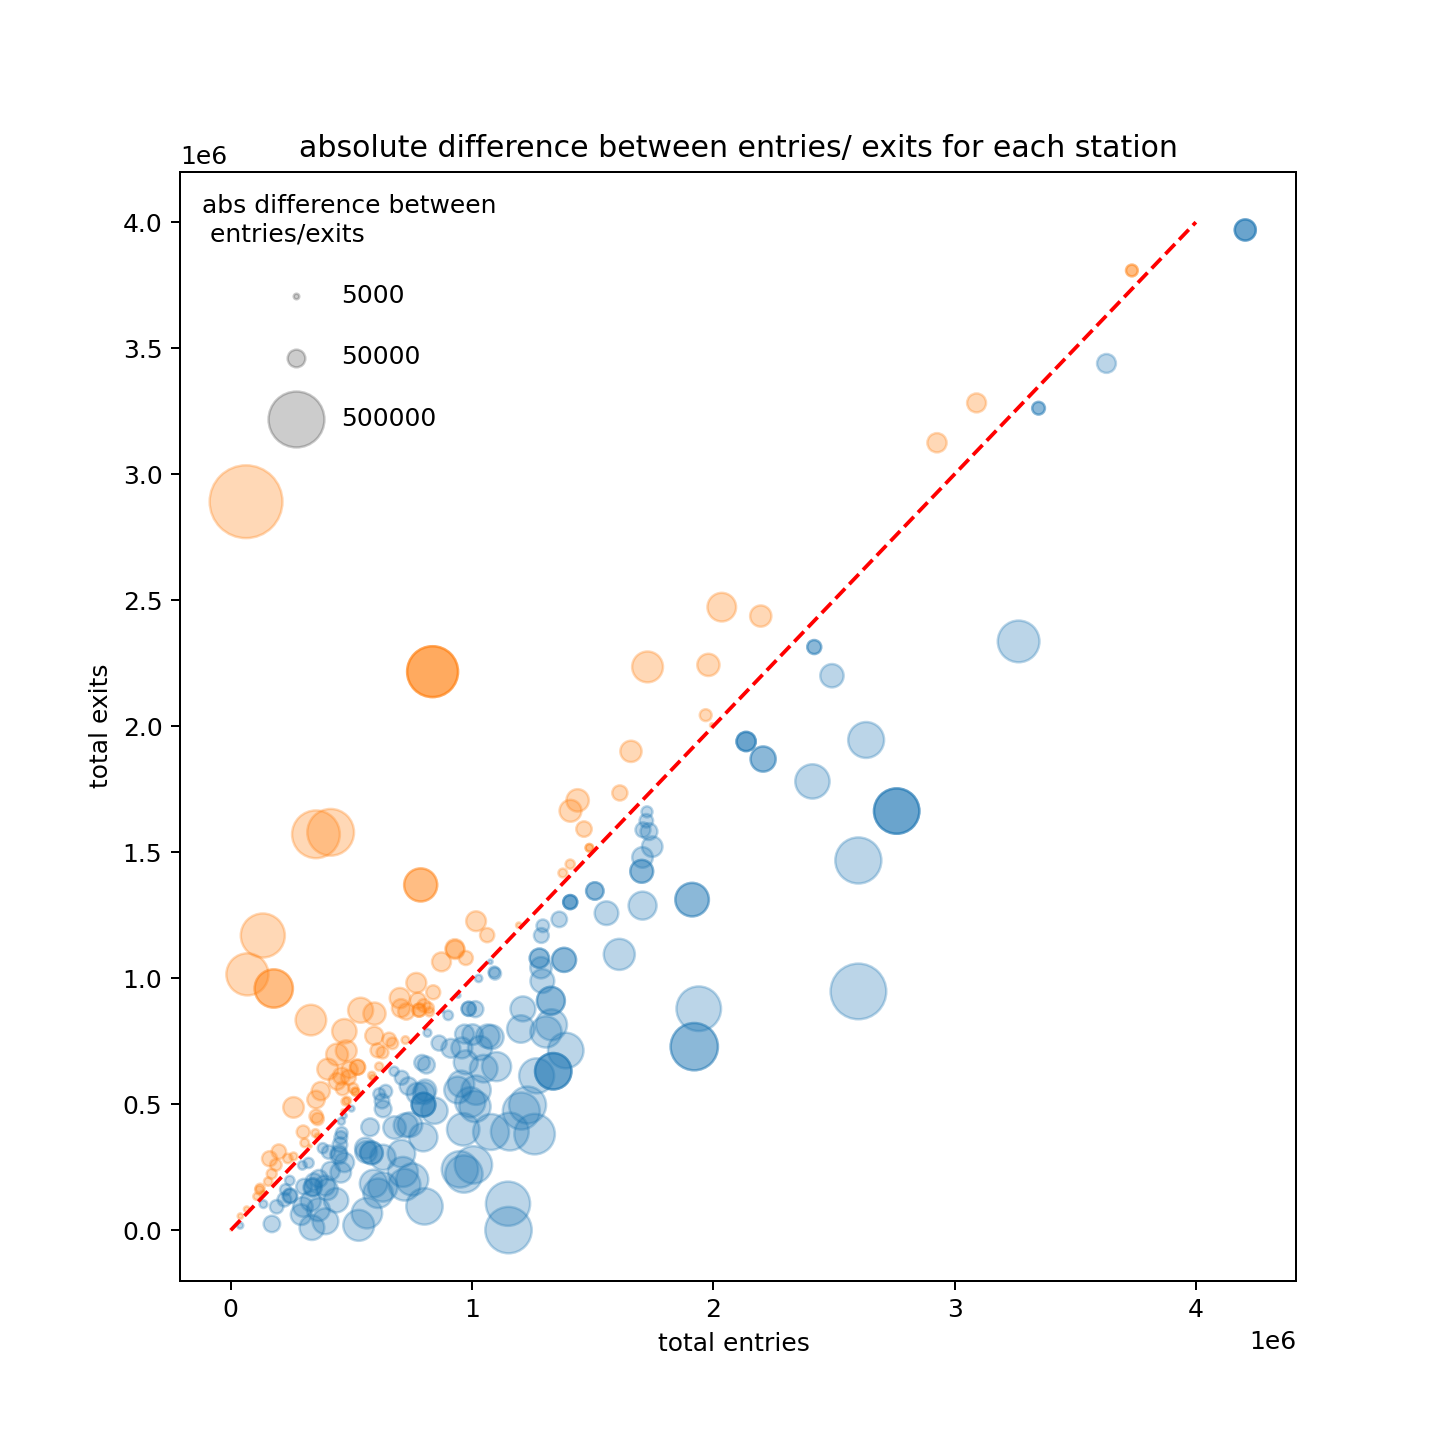

In [232]:
smap = sttgdf[(sttgdf['Ext_dif'] >= sttgdf['Ext_dif'].quantile(0.01)) & (sttgdf['Ext_dif'] <= sttgdf['Ext_dif'].quantile(0.97))\
         &(sttgdf['Ext_dif'] >= sttgdf['Ext_dif'].quantile(0.01)) & (sttgdf['Ext_dif'] <= sttgdf['Ext_dif'].quantile(0.97))\
              &(sttgdf['abs_dif'] >= sttgdf['abs_dif'].quantile(0.01)) & (sttgdf['abs_dif'] <= sttgdf['abs_dif'].quantile(0.97))\
             &(sttgdf['normDif'] >= sttgdf['normDif'].quantile(0.01)) & (sttgdf['normDif'] <= sttgdf['normDif'].quantile(0.97))\
             &(sttgdf['Ent_dif'] >0) & (sttgdf['Ext_dif']>0)] 
ta = smap[smap.abs_dif > 0]
tb = smap[smap.abs_dif < 0]
fig, ax = plt.subplots(figsize = (8,8))
ta = smap[smap.abs_dif > 0]
tb = smap[smap.abs_dif < 0]

# plt.scatter(taa.Ent_dif,taa.Ext_dif , alpha = 0.3,  s = 0.0003 * taa.abs_dif)
plt.scatter(ta.Ent_dif,ta.Ext_dif , alpha = 0.3,  s = 0.0003 * ta.abs_dif)
plt.scatter(tb.Ent_dif,tb.Ext_dif , alpha = 0.3,  s = -0.0003 * tb.abs_dif)
plt.title('absolute difference between entries/ exits for each station', fontsize=12)
plt.xlabel('total entries ', fontsize=10)
plt.ylabel('total exits', fontsize=10)
plt.plot([0, 4e6], [0,4e6], '--', c = 'r')


for dif in [5, 50, 500]:
    plt.scatter([], [], c='k', alpha=0.2, s=dif,
               label=str(dif*1000))
plt.legend(scatterpoints=1, frameon=False,
                  labelspacing=1.5, title='abs difference between \n entries/exits')
# plt.legend()

<IPython.core.display.Javascript object>


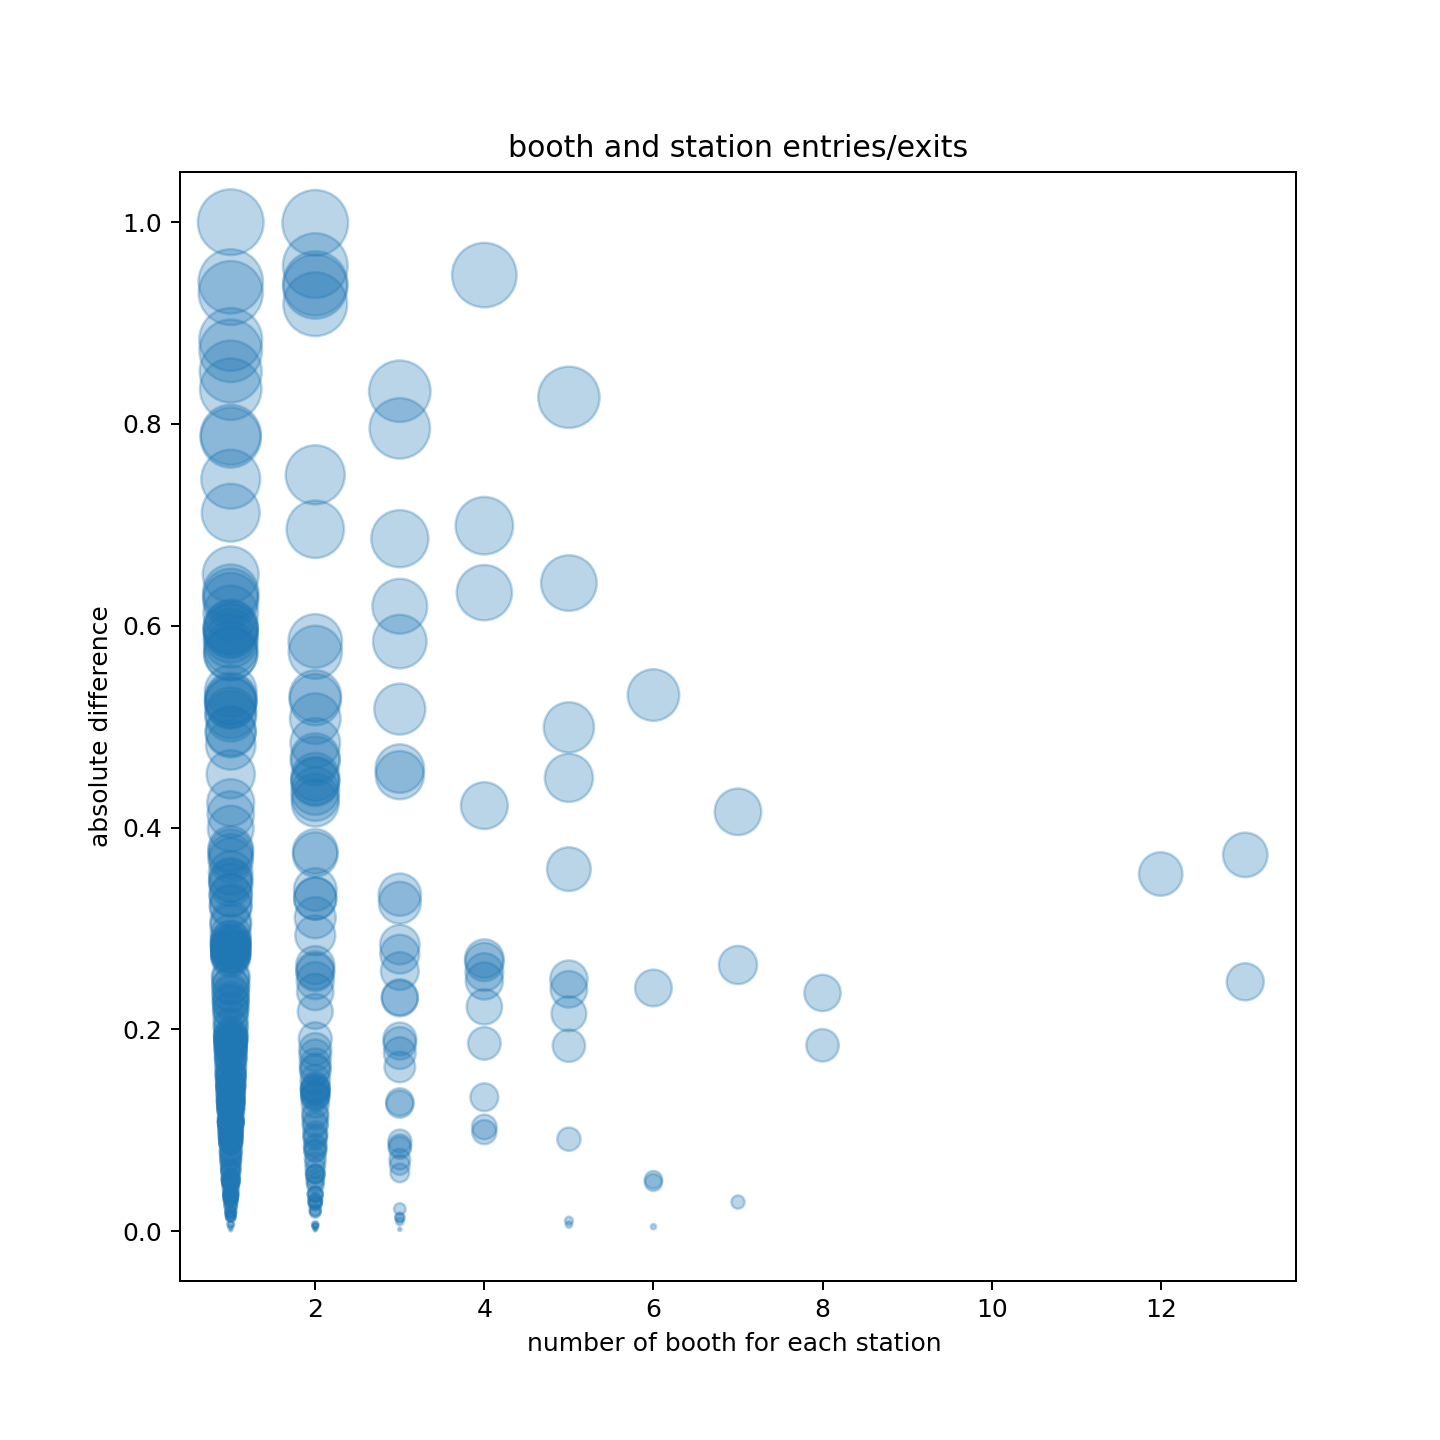

Text(0, 0.5, 'absolute difference')

In [301]:
###########################
## booth and entry/exit difference
###########################

## add number of booth 
Nbooth = df_net_clean[['Station','C/A']].drop_duplicates().groupby(by = 'Station').agg({'C/A':'count'}).reset_index()
sttb = stt.merge(Nbooth, left_on = 'Station', right_on ='Station', how = 'inner')
sttb['abs_dif_p'] = np.abs(sttb['abs_dif'])
h = sttb[(sttb['abs_dif_p']<1e7)]
g = sttb[(np.abs(sttb['normDif'])<=1)]

fig, ax = plt.subplots(figsize = (8,8))
# plt.scatter(taa.Ent_dif,taa.Ext_dif , alpha = 0.3,  s = 0.0003 * taa.abs_dif)
plt.scatter(g['C/A'],np.abs(g.normDif) , alpha = 0.3,  s = (1000*np.log(np.abs(g.normDif)+1)))
plt.title('booth and station entries/exits', fontsize=12)
plt.xlabel('number of booth for each station ', fontsize=10)
plt.ylabel('absolute difference', fontsize=10)

# for dif in [3, 30, 300]:
#     plt.scatter([], [], c='k', alpha=0.2, s=dif,
#                label=str(dif/0.00003))
# plt.legend(scatterpoints=1, frameon=False,
#                   labelspacing=1.5, title='abs difference between \n entries/exits')

### 4. to be continued

In [97]:
# an example for outliers happen due to reset counters:

# test = f.loc[(f['C/A'] == 'A002')&(f['Unit'] == 'R051')&(f['SCP']=='02-00-00')&((f['C/A'] == 'A002')&(f['month']==9))]
# test = test.reset_index()
# test.iloc[70:90,] # the abnormal volume difference is due to counter reset (i.e., description = recover Aud)

In [56]:
# ### check if calculated correctly
# ### compare with the above df, it is right. only these four have no entry/exit data on Dec 31.
# lastd = list(df2[(df2['month'] == 12)&(df['day'] == 31)]['C/A'].unique())
# df2[~df2['C/A'].isin(lastd)]['C/A'].unique()

# ## remove negative value - counter will always add number, 
# ## so the end state of a counter should always be larger than the begining state.
# df_net = df_net.loc[(df_net.Ent_dif >0)&(df_net.Ext_dif > 0)]


# #filter out the outliers
# df_clean = df_clean[(df_clean['Entries'] >= df_clean['Entries'].quantile(0.01)) & (df_clean['Entries'] <= df_clean['Entries'].quantile(0.99))\
#          &(df_clean['Exits'] >= df_clean['Exits'].quantile(0.01)) & (df_clean['Exits'] <= df_clean['Exits'].quantile(0.99))] 
# df3.shape

# ###################
# #### for each chanel at a booth of a station,
# #### we are checking if their cumulative counter works during the minimum observation time window.
# ##################

# # ## (take really really long time for processing, use the following function instead.)
# # f = df[['C/A', 'Unit', 'SCP', 'Station', 'Date', 'Entries', 'Exits', 'month', \
# #         'day','hour']].groupby(by = ['C/A','Unit','SCP','Date','hour']).apply(lambda x: x)

# f = df.sort_values(by = ['C/A','Unit','SCP','Date','hour','minute'], ascending = False)

# # check if the cumulative counter works during a certain time window
# f['lag_Ent'] = f['Entries'].shift(1)
# f['lag_Ext'] = f['Exits'].shift(1)

# f['dif_Ent'] = f['lag_Ent'] - f['Entries']
# f['dif_Ext'] = f['lag_Ext'] - f['Exits']

# # remove those unreasonable lag difference (e.g., the volume difference among two adjacent channels )
# marker = f.drop_duplicates(['C/A','Unit','SCP'], keep='first')
# f_clean = f.loc[~(f.index.isin(marker.index))]
# print(f_clean.shape)

# f_clean = f_clean.loc[(f_clean.dif_Ent > 0)&(f_clean.dif_Ext > 0)] # counter value should be accumulatively increase 
# f_clean = f_clean.loc[(f_clean.dif_Ent < 1000000)&(f_clean.dif_Ext < 1000000)] # remove side effect of reset counter.
# print(f_clean.shape) # we now have around 62% data.

array(['J032', 'OB01', 'R148', 'R183'], dtype=object)